# Time Series Prediction with Lotka Volterra Equation Inspired Deep Learning ($LVPINN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-12 17:44:10

## Gathering Dependencies

_Importing Required Libraries_

In [13]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [14]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Pretraining

_Lotka Volterra Intermittency_

The `lotka_volterra_intermittency.dat` is generated from the Runge Kutta Method.

This feeds the model with the dynamics of the Lotka Volterra Equations

In [15]:
data = np.genfromtxt('datasets/lotka_volterra_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [16]:
t_diff = 1 # Daily Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

215.48740705
1        -1.078114e-02
2        -1.066358e-02
3        -1.054729e-02
4        -1.043229e-02
5        -1.031852e-02
              ...     
139867   -1.113760e-34
139868   -1.101721e-34
139869   -1.089814e-34
139870   -1.078034e-34
139871   -1.066382e-34
Name: 1, Length: 139871, dtype: float64
2         1.175600e-04
3         1.162900e-04
4         1.150000e-04
5         1.137700e-04
6         1.125200e-04
              ...     
139867    1.217000e-36
139868    1.203900e-36
139869    1.190740e-36
139870    1.177950e-36
139871    1.165160e-36
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_दिल्ली WIND SPEED_

In [17]:
data = pd.read_csv("datasets/delhi.csv")
training_set = data.iloc[:, 3]
print(training_set)

0       0.000000
1       2.980000
2       4.633333
3       1.233333
4       3.700000
          ...   
1457    3.547826
1458    6.000000
1459    6.266667
1460    7.325000
1461    0.000000
Name: wind_speed, Length: 1462, dtype: float64


In [18]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0        -1.078114e-02
1        -1.066358e-02
2        -1.054729e-02
3        -1.043229e-02
4        -1.031852e-02
              ...     
139866   -1.113760e-34
139867   -1.101721e-34
139868   -1.089814e-34
139869   -1.078034e-34
139870   -1.066382e-34
Name: 1, Length: 139871, dtype: float64
0         1.175600e-04
1         1.162900e-04
2         1.150000e-04
3         1.137700e-04
4         1.125200e-04
              ...     
139865    1.217000e-36
139866    1.203900e-36
139867    1.190740e-36
139868    1.177950e-36
139869    1.165160e-36
Name: 1, Length: 139870, dtype: float64


In [19]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Preprocessing the Data into Supervised Learning

In [20]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)


    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10    0.000000   2.980000   4.633333   1.233333   3.700000   1.480000   
11    2.980000   4.633333   1.233333   3.700000   1.480000   6.300000   
12    4.633333   1.233333   3.700000   1.480000   6.300000   7.142857   
13    1.233333   3.700000   1.480000   6.300000   7.142857  12.500000   
14    3.700000   1.480000   6.300000   7.142857  12.500000   7.400000   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)    var1(t)   var2(t)   var3(t)  
10   6.300000   7.142857  12.500000   7.400000  10.571429 -0.009662  0.000105  
11   7.142857  12.500000   7.400000  10.571429  13.228571 -0.009556  0.000104  
12  12.500000   7.400000  10.571429  13.228571   4.633333 -0.009452  0.000103  
13   7.400000  10.571429  13.228571   4.633333   0.616667 -0.009349  0.000102  
14  10.571429  13.228571   4.633333   0.616667   0.528571 -0.009247  0.000101  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       '

## Train and Test Split

In [21]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1160, 1, 10) (1160, 3) (291, 1, 10) (291, 3)


## Model ($LVPINN$)

In [22]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64,
                    validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/500
19/19 - 24s - loss: 0.2847 - val_loss: 0.2558 - 24s/epoch - 1s/step
Epoch 2/500
19/19 - 0s - loss: 0.2061 - val_loss: 0.1671 - 471ms/epoch - 25ms/step
Epoch 3/500
19/19 - 0s - loss: 0.1364 - val_loss: 0.0910 - 483ms/epoch - 25ms/step
Epoch 4/500
19/19 - 0s - loss: 0.0819 - val_loss: 0.0404 - 380ms/epoch - 20ms/step
Epoch 5/500
19/19 - 0s - loss: 0.0519 - val_loss: 0.0196 - 430ms/epoch - 23ms/step
Epoch 6/500
19/19 - 1s - loss: 0.0435 - val_loss: 0.0158 - 511ms/epoch - 27ms/step
Epoch 7/500
19/19 - 1s - loss: 0.0434 - val_loss: 0.0151 - 518ms/epoch - 27ms/step
Epoch 8/500
19/19 - 0s - loss: 0.0432 - val_loss: 0.0145 - 476ms/epoch - 25ms/step
Epoch 9/500
19/19 - 0s - loss: 0.0424 - val_loss: 0.0139 - 340ms/epoch - 18ms/step
Epoch 10/500
19/19 - 0s - loss: 0.0415 - val_loss: 0.0134 - 460ms/epoch - 24ms/step
Epoch 11/500
19/19 - 0s - loss: 0.0407 - val_loss: 0.0130 - 383ms/epoch - 20ms/step
Epoch 12/500
19/19 - 0s - loss: 0.0400 - val_loss: 0.0125 - 324ms/epoch - 17ms/step
Epoc

## Metrics ($LVPINN$)

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

10/10 [==============================] - 6s 4ms/step
(291, 3)
(291, 10)
Test RMSE: 3.535
Test MAE: 2.670


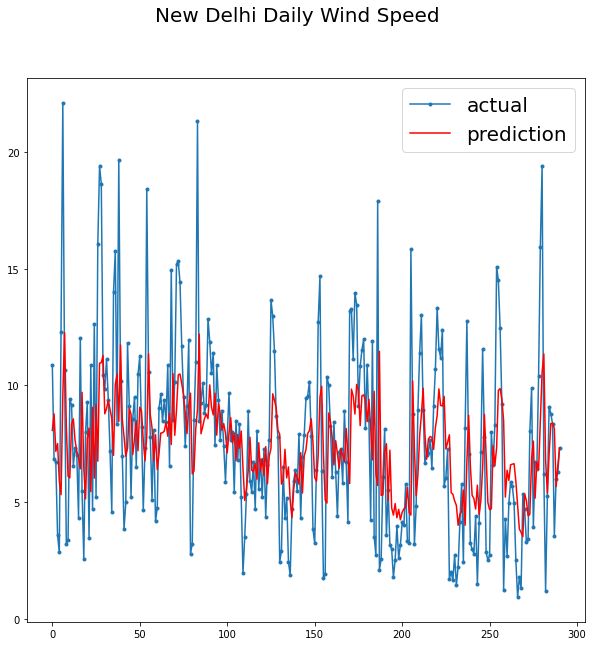

In [24]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('New Delhi Daily Wind Speed', fontsize=20)
plt.legend(fontsize=20)
plt.show()